In [1]:
import keras.backend as K
import numpy as np
import numpy as np

np.random.seed(1337)  # for reproducibility
from keras.models import *
from keras.layers import Input, Dense, merge

Using TensorFlow backend.


In [2]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

In [3]:
input_dim = 32
att_col = 3

In [4]:
def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [5]:
N = 10000
inputs_1, outputs = get_data(N, input_dim, attention_column=att_col)

m = build_model()
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
attention_vec (Dense)            (None, 32)            1056        input_1[0][0]                    
____________________________________________________________________________________________________
attention_mul (Merge)            (None, 32)            0           input_1[0][0]                    
                                                                   attention_vec[0][0]              
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 64)            2112        attention_mul[0][0]     

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


In [18]:
hist = m.fit([inputs_1], outputs, epochs=15, batch_size=64, validation_split=0.5)


Train on 5000 samples, validate on 5000 samples
Epoch 1/15
5000/5000 [==============================] - 0s - loss: 0.3354 - acc: 0.8764 - val_loss: 0.3008 - val_acc: 0.8888
Epoch 2/15
5000/5000 [==============================] - 0s - loss: 0.2184 - acc: 0.9312 - val_loss: 0.1844 - val_acc: 0.9504
Epoch 3/15
5000/5000 [===============

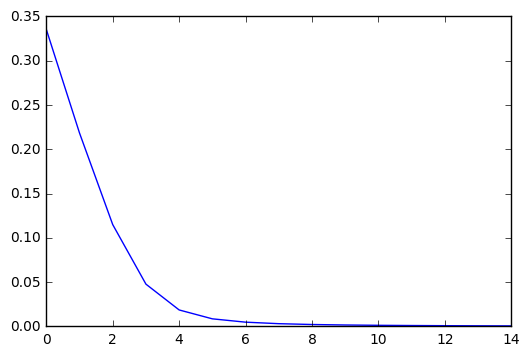

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'])

In [28]:
testing_inputs_1, testing_outputs = get_data(1, input_dim, attention_column=att_col)
print testing_outputs

[[1]]


In [29]:
attention_vector = get_activations(m, testing_inputs_1,
                                       print_shape_only=True,
                                       layer_name='attention_mul')[0].flatten()
print('attention =', attention_vector)

----- activations -----
(1, 32)
('attention =', array([-0.01168117, -0.01834757,  0.00223917,  0.56905454, -0.04397946,
        0.00488129, -0.00741593,  0.01713926, -0.00674188,  0.00594741,
        0.01199276, -0.00273571, -0.00533627, -0.02711043,  0.00805609,
        0.00494864,  0.00533909, -0.00309587,  0.00182709,  0.01349095,
        0.08861666, -0.0086869 ,  0.00850665,  0.00848093, -0.00518114,
        0.0149546 ,  0.00555036, -0.01243154, -0.03953381,  0.00196551,
        0.04368611, -0.00235699], dtype=float32))


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

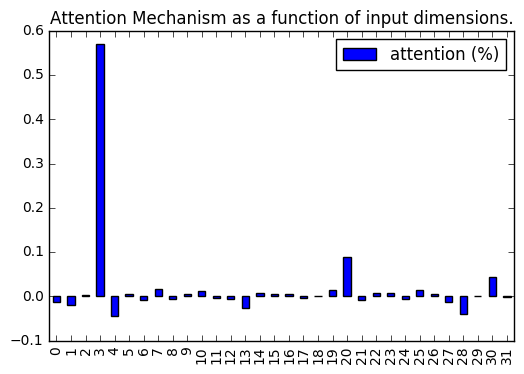

In [31]:
pd.DataFrame(attention_vector, columns=['attention (%)']).plot(kind='bar',
                                                                   title='Attention Mechanism as '
                                                                         'a function of input'
                                                                         ' dimensions.')
plt.show()